# **PROYECTO FINAL  - DATA SCIENCE - CODERHOUSE**
 ENTREGA FINAL




## **Objetivos de la Invetigacion:** 
**Objetivo principal:** Analisis de Sentimiento sobre Reviews de Videojuegos con aplicación simple de NLP.

**Objetivo secundario**: Analisis exploratorio de las variables secundarias para conocer su relacion con respecto a la variable target.



**Conformacion del equipo de trabajo:**
*     Ignacio Manuel Vallecillo<br>
*   Francisco Lopez Ballent<br>
* Gerardo Heidel<br>

# **1. Data Adquisition**

**Informacion del Dataset:**

  Seleccionamos dos dataset con la siguientes caracteristicas:
1.   Steam Reviews


*   **Contenido Original:** 6.4 Millones de Reviews en Ingles de diferentes juegos publicados en la plataforma Steam de Valve.

*   **Fuente:** Kaggle

*  **URL:** https://www.kaggle.com/datasets/andrewmvd/steam-reviews


2.   Steam Store Games
*   **Contenido Original:** Data combinada de mas de 27.000 juegos scrapeados de la plataforma Steam y de SteamSpy APIs.

*   **Fuente:** Kaggle

*  **URL:** https://www.kaggle.com/datasets/nikdavis/steam-store-games

## 1.1 Aclaraciones sobre la conformacion del Dataset

Debido a la inmensidad del Dataset Orignal de las Steam Reviews, se decidio tomar 100000 reviews mitad positivas y mitad negativas seleccionadas de manera aleatoria. Al mismo, decidimos integrarle informacion adicional de cada uno de los juegos al que pertenecen las reviews. Para ello, mergeamos la información del dataset Steam Store Games que creemos pertinente para la investigacion.

## 1.2 Importacion de librerias y lectura de Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Generales
import pandas as pd
import numpy as np
import re
import random
#Visualizacion
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#Machine Learning
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
import spacy
import tensorflow as tf
#Guardado y lectura de modelos
import joblib
#Otros
import warnings
warnings.filterwarnings('ignore')

Cambio de estilo de graficas

In [ ]:
mpl.style.use('dark_background')
mpl.rcParams.update({'font.size': 20})

Cargamos el dataset que contiene la informacion sobre los videojuegos.

In [ ]:
df_data_steam = pd.read_csv('/content/drive/MyDrive/Proyecto_Final_DS/Datasets/steam.csv')
df_data_steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


Cargamos el dataset que contiene las reviews, tanto positivas como negativas.

In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/Proyecto_Final_DS/Datasets/reviews_full.csv')
df_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


**Seleccionamos de manera aleatoria 50K reviews positivas y 50K negativas para balancear el dataset**

In [ ]:
df_pos = df_reviews[df_reviews.review_score == 1].sample(50000, random_state=10)
df_neg = df_reviews[df_reviews.review_score == -1].sample(50000, random_state=10)
df_reviews = pd.concat([df_pos, df_neg])

**Merge de data de Reviews y data de Games para formar el dataset que vamos a usar**

In [ ]:
df_data_steam = df_data_steam.rename(columns={'appid':'app_id'})
df = df_reviews.merge(right=df_data_steam, how='inner',on='app_id')
df.head()

,app_id,app_name,review_text,review_score,review_votes,name,release_date,english,developer,publisher,...,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,203160,Tomb Raider,Fantastic reboot; revitalizes the franchise an...,1,0,Tomb Raider,2013-03-04,1,Crystal Dynamics;Eidos-Montréal;Feral Interact...,Square Enix;Feral Interactive (Mac);Feral Inte...,...,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,Adventure;Action;Female Protagonist,50,93509,4103,527,475,5000000-10000000,14.99
1,203160,Tomb Raider,"Really awesome, if you liked Uncharted games y...",1,0,Tomb Raider,2013-03-04,1,Crystal Dynamics;Eidos-Montréal;Feral Interact...,Square Enix;Feral Interactive (Mac);Feral Inte...,...,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,Adventure;Action;Female Protagonist,50,93509,4103,527,475,5000000-10000000,14.99
2,203160,Tomb Raider,Tomb Raider is the prequel to the original Tom...,1,0,Tomb Raider,2013-03-04,1,Crystal Dynamics;Eidos-Montréal;Feral Interact...,Square Enix;Feral Interactive (Mac);Feral Inte...,...,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,Adventure;Action;Female Protagonist,50,93509,4103,527,475,5000000-10000000,14.99
3,203160,Tomb Raider,This is a great game with lots of exciting mom...,1,0,Tomb Raider,2013-03-04,1,Crystal Dynamics;Eidos-Montréal;Feral Interact...,Square Enix;Feral Interactive (Mac);Feral Inte...,...,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,Adventure;Action;Female Protagonist,50,93509,4103,527,475,5000000-10000000,14.99
4,203160,Tomb Raider,A truly epic game that will appeal to any fan ...,1,0,Tomb Raider,2013-03-04,1,Crystal Dynamics;Eidos-Montréal;Feral Interact...,Square Enix;Feral Interactive (Mac);Feral Inte...,...,Single-player;Multi-player;Steam Achievements;...,Action;Adventure,Adventure;Action;Female Protagonist,50,93509,4103,527,475,5000000-10000000,14.99


## 1.3 Descripcion del dataset

**Diccionario de Parámetros**

*   **app_id:** ID unico para cada titulo.
*   **app_name:** Nombre del juego.
*   **review_text:** Contenido de la review. 
*  **review_score:** Valoracion de la review (1 -> Positiva / 0 -> Negativa).  [**Variable target]**
*  **review_votes:** Valoracion de otros usuarios a la review (1 -> Tiene valoraciones positivas / 0 -> No tiene valoraciones positivas).
* **release_date:** Formato Año-Mes-Dia.
* **english:** Si el idioma es Ingles o no / 1 = True, 0 = False .
* **developer:** Empresa o persona que desarrollo  el juego.
* **publisher:** Nombre o nombres de los Publicantes. Se usa un (;) para delimitar si son multiples.
* **platforms:** Lista de Sist Op soportados delimitada por (;)
* **required_age:** Mínimo de edad requerida segun PEGI UK standards. Figura (0) para aquellos no clasificados o no suministrados. 
* **categories:** Lista de categorias de juegos delimitada por (;)
* **genres:** Lista de géneros de juegos delimitada por (;)
* **steamspy_tags:** Lista de los top steamspy game tags, que son similares a los generos pero votados por la comunidad gamer.
* **achievements:** Número de logros in-game sí hay.
* **positive_ratings:** Cantidad de valoraciones positivas del juego segun SteamSpy.
* **negative_ratings:** Cantidad de valoraciones negativas del juego segun SteamSpy.
* **average_playtime:** Promedio de tiempo de juego segun SteamSpy.
* **median_playtime:** Mediana de tiempo de juego segun SteamSpy.
* **owners:** Rango estimado de propietarios del juego. Contiene el limite Inferior y Superior.
* **price:** Precio actualizado del juego en GBP (Libras Esterlinas)






Limpieza de columnas que no vamos a usar como **'name'**, ya que hace referencia al nombre del juego que ya esta contemplado en **'app_name'**.

In [ ]:
df = df.drop(columns=['name', 'steamspy_tags', 'achievements', 'english', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners'])

Tipo de dato de cada columna

In [ ]:
df.dtypes

app_id            int64
app_name         object
review_text      object
review_score      int64
review_votes      int64
release_date     object
developer        object
publisher        object
platforms        object
required_age      int64
categories       object
genres           object
price           float64
dtype: object

Shape

In [ ]:
print(f'El dataset tiene:\n -> {df.shape[0]} filas\n -> {df.shape[1]} columnas') 

El dataset tiene:
 -> 90062 filas
 -> 13 columnas


Cantidad de juegos

In [ ]:
print(f' -> {df.app_name.nunique()} juegos') 

 -> 5303 juegos


Cantidad de missing values en porcentaje

In [ ]:
df.isna().sum()/df.shape[0]*100

app_id          0.000000
app_name        1.445671
review_text     0.089938
review_score    0.000000
review_votes    0.000000
release_date    0.000000
developer       0.000000
publisher       0.000000
platforms       0.000000
required_age    0.000000
categories      0.000000
genres          0.000000
price           0.000000
dtype: float64

# **2. Preprocesamiento de los datos**

Eliminamos aquellos valores que tienen missing values en "review_text" y chequeamos que el dataset siga balanceado

In [ ]:
df = df.dropna(subset=['review_text'])
df_aux = df.review_score.value_counts(normalize=True)
print(f'Reviews positivas (1) -> {df_aux.iloc[0].round(2)*100}%\nReviews negativas (-1) -> {df_aux.iloc[1].round(2)*100}%')

Reviews positivas (1) -> 51.0%
Reviews negativas (-1) -> 49.0%


###2.1 Limpieza del dataset



Veamos algunos valores random para saber con que nos encontramos

In [ ]:
random.seed(6)
random_idx_list = [random.randint(1,len(df.review_text)) for i in range(15)] 
random_rev_text = [df.loc[random_idx_list].review_text.head(15).iloc[i] for i in range(14)]
for i, rev in zip(range(15), random_rev_text):
  print(f'{i} -> {rev}\n')

0 -> Just the right amount of creepy.

1 ->  Early Access Review

2 ->  Early Access Review

3 -> This is the original x-com. I ♥♥♥♥ing love it, great game! Still holds up today.

4 -> I absolutely recommend this game to everybody. one fatal issue right now is the fact that steam have decided to no longer make 4-packs ..meaning people will have to pay for this game at full price multiple times for their friends or have them pay the money. I know for a fact that people who want to play this would much prefer to buy it at a lower price seeing as bundles are no longer a thing. Or to have them pull their finger out and give us what we want. It's an amazing, fun, action-packed, goofy 3rd person artistic masterpiece filled with nostalgia and childhood wonders.  Most definetly a game to play with friends, online or privately, it's a perfect party game. With each of the classic 'green army men' weapons to choose from, you can flip between them all over without the need for time consuming class

Vemos que steam sensura malas palabras con corazones como en la (8), y tambien observamos que "Early Access Review" es una frase que se repite bastante. Por ahora lo de los corazones lo vamos a dejar asi pero veamos que porcentaje de reviews tenemos con la frase "Early Access Review".

In [ ]:
df_ear = df[df['review_text'].str.contains("Early Access Review")]
df_ear_reviews = df_ear.review_text
round(df_ear_reviews.count()/df.shape[0]*100, 2)

17.39

Veamos si esta frase tiene una tendencia a ser calificada como positiva o negativa.

In [ ]:
df_ear_reviews_pos = df_ear.loc[df_ear['review_score'] == 1]
df_ear_reviews_neg = df_ear.loc[df_ear['review_score'] == -1]
perc_pos = df_ear_reviews_pos.review_score.count()/df_ear.shape[0]*100
perc_neg = df_ear_reviews_neg.review_score.count()/df_ear.shape[0]*100
print(f'% Positivas -> {round(perc_pos, 2)}\n% Negativas -> {round(perc_neg, 2)}')

% Positivas -> 46.92
% Negativas -> 53.08


No se observa una tendencia a que las reviews con "Early Access Review" sean evaluadas como positivas o negativas. Por lo tanto no nos aportan informacion y podemos eliminarlas.

In [ ]:
df = df.drop(df_ear.index)

Eliminamos todas las reviews que tengan mas de 150 palabras

In [ ]:
df = df[df['review_text'].str.split().str.len() < 150]  

**Observemos como queda el dataset conformado:**

In [ ]:
print(f'El dataset tiene:\n -> {df.shape[0]} filas\n -> {df.shape[1]} columnas') 

El dataset tiene:
 -> 64816 filas
 -> 13 columnas


In [ ]:
df_aux2 = df.review_score.value_counts(normalize=True)
print(f'Reviews positivas (1) -> {df_aux2.iloc[0].round(2)*100}%\nReviews negativas (-1) -> {df_aux2.iloc[1].round(2)*100}%')

Reviews positivas (1) -> 54.0%
Reviews negativas (-1) -> 46.0%


A continuación haremos una limpieza sobre el texto de las reviews:
*   **Stopwords**: Palabras usadas comunmente en cualquier idioma, por ejemplo en ingles "i", "who", "it", etc.  
*   **Hyperlinks**: Eliminamos todos los links como 'https://youtube.com...' que no aportan al objetivo 
*   **Puntuacion (, . : ;)** 
*   **Palabras con numeros (Ej: H3ll0)**<br>




In [ ]:
import re
import string
import nltk

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

Aplicamos las funciones de limpieza al dataset a traves de una funcion lambda.

In [ ]:
df.review_text = df.review_text.apply(str).apply(lambda x: text_preprocessing(x)) 

###2.2 WordClouds

Analizamos cuales son las palabras mas usadas en las reviews. Para esto hacemos uso de la libreria WordCloud la cual nos permite generar una nube de palabras donde se puede visualizar facilmente cuales son las mas frecuentes

In [ ]:
def wcloud(w_input, tag=''):
  reviews = " ".join(w_input)
  word_cloud = WordCloud(max_words = 2000, background_color='black', width=800, height=400).generate(reviews)
  plt.rcParams["figure.figsize"] = (12, 8)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Palabras mas usadas en las Reviews {tag}',fontweight='bold')
  return

**WordCloud de Reviews Positivas**

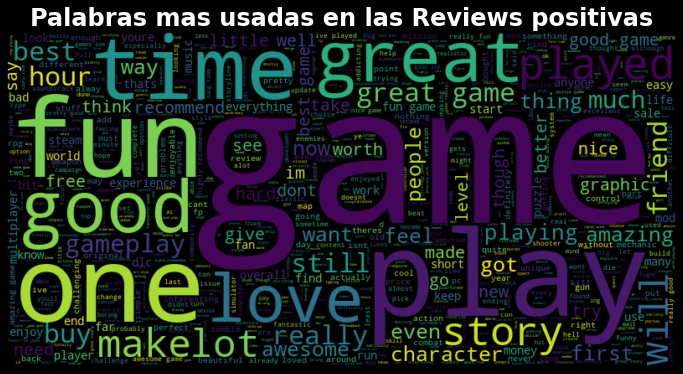

In [ ]:
wcloud_pos = wcloud(df[df.review_score == 1].review_text, 'positivas')

**WordCloud de Reviews Negativas**

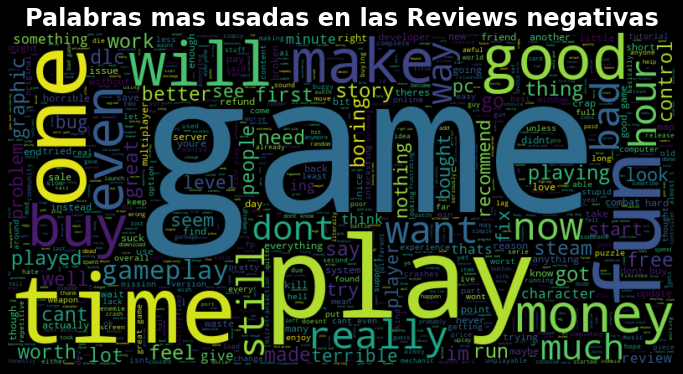

In [ ]:
wcloud_neg = wcloud(df[df.review_score == -1].review_text, 'negativas')

**Nota:** Este tipo de graficos nos ayudo a darnos cuenta que teniamos frases muy repetidas como "Early Access Review", la cual afectaba en la calidad de los datos para entrenar el modelo, que como se pudo observar anteriormente, erradicamos dichas reviews.

### **2.3 Tokenizacion**<br>
Armamos un nuevo dataframe donde transformamos a las reviews en vectores numéricos para mejorar el análisis. Para esto, usamos la tecnica de Bag of Words la cual nos genera una tabla que tiene como columnas, todas las palabras que se utilizan en las reviews y como filas, cada review con la cantidad de veces que aparece cada palabra en la review.

In [ ]:
full_list_reviews = df.review_text
pattern = '[a-zA-z]+'
vect = CountVectorizer(token_pattern=pattern, ngram_range=(1, 2), max_features=1000)
vect.fit(full_list_reviews)
tokenized_features = vect.transform(full_list_reviews)
features_vect = pd.DataFrame(data=tokenized_features.toarray(), columns=vect.get_feature_names_out())
features_vect.head()

,a,a bad,a bit,a few,a fun,a game,a good,a great,a little,a long,...,you should,you to,you want,you will,youll,your,your money,youre,yourself,zombies
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Agregamos columnas del dataset original que nos van a ser utiles para el analisis

In [ ]:
features_vect = features_vect.join(pd.DataFrame({'_score': df.review_score, 
                                                 '_votes': df.review_votes, 
                                                 '_genre': df.genres, 
                                                 '_price': df.price,
                                                 '_word_count': df.review_text.str.count(pattern),
                                                 '_avg_word_length': df.review_text.str.count(r"\S")/df.review_text.str.count(pattern)}, 
                                                index=features_vect.index))

# **3. Analisis exploratorio de los datos (EDA)**

##**3.1 Analisis de variables principales**

En esta seccion vamos a analizar la variable dependiente (review_text) y la variable target (review_score)

###**3.1.1 Cantidad de palabras por review**


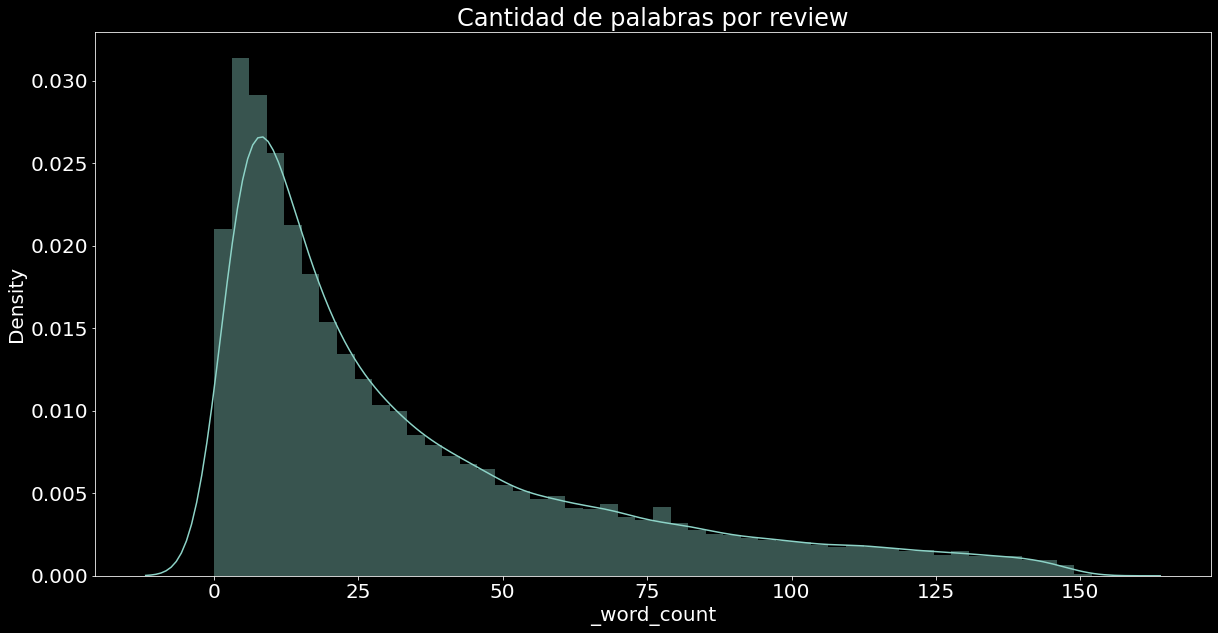

In [ ]:
plt.figure(figsize=(20, 10))

feature_vect_pd = features_vect['_word_count']
sns.distplot(a=feature_vect_pd, hist=True)
plt.title('Cantidad de palabras por review')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/palabras_dist.png', transparent=True)

>**Conclusión:** Podemos ver que principalmente tenemos comentarios de no mas de 50 palabras. Se puede observar una asimetria positiva dada por tener algunos comentarios con una cantidad de palabras considerable. 

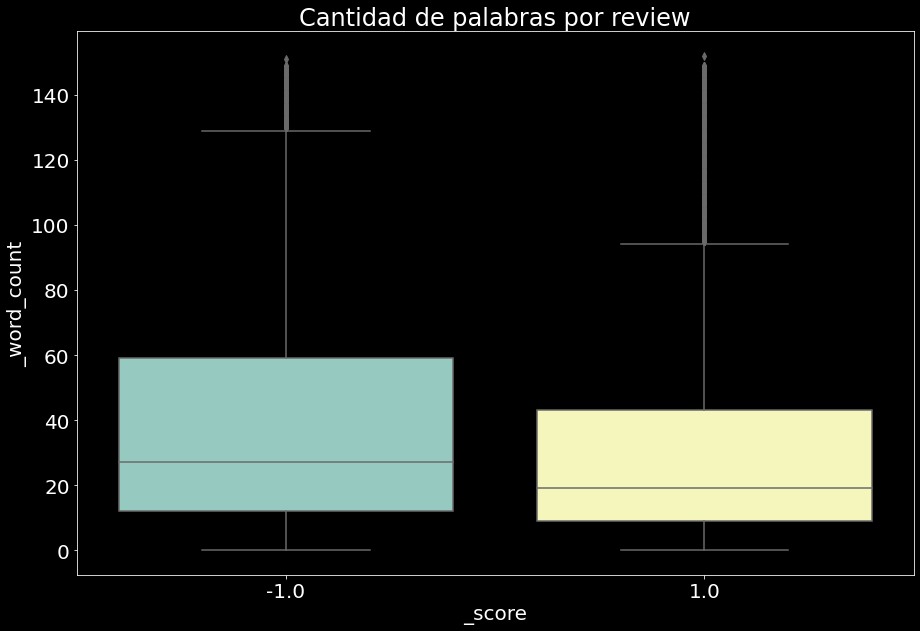

In [ ]:
plt.figure(figsize=(15, 10))

sns.boxplot(data=features_vect, x='_score', y='_word_count')
plt.title('Cantidad de palabras por review')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/palabras_boxplot.png', transparent=True)

**Conclusion**: Se puede observar que la cantidad de palabras utilizadas en las reviews negativas es en promedio mayor por amplio margen.

Text(0.5, 1.0, 'Promedio de palabras usadas en reviews positivas o negativas')

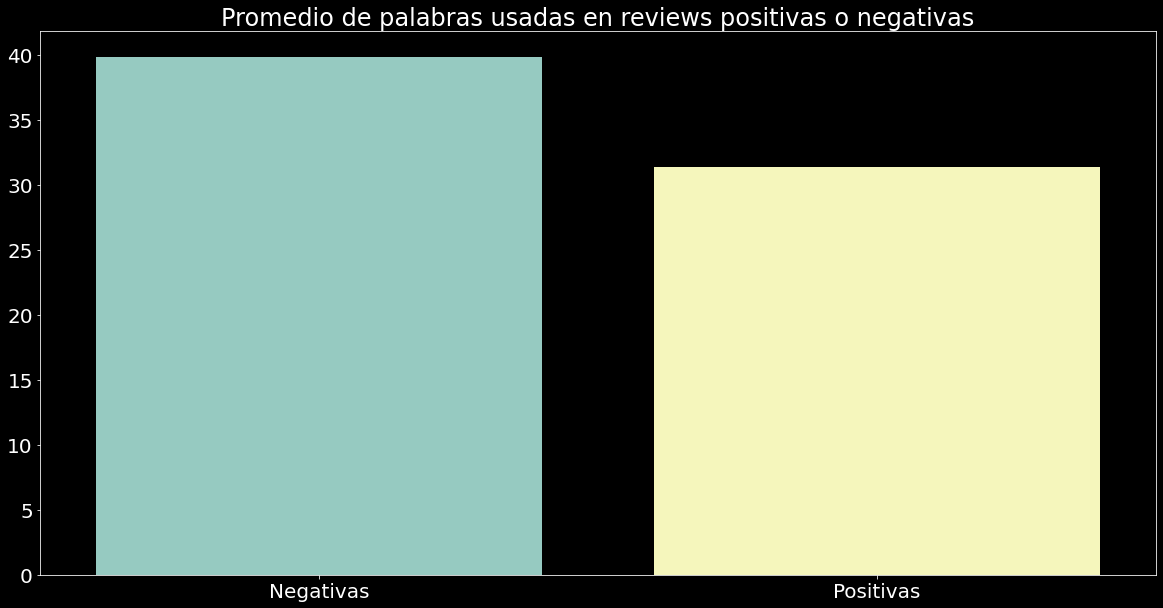

In [ ]:
avg_words_pos = features_vect[features_vect['_score'] == 1]['_word_count'].mean()
avg_words_neg = features_vect[features_vect['_score'] == -1]['_word_count'].mean()
plt.figure(figsize = (20, 10))
sns.barplot(x=['Negativas', 'Positivas'], y = [avg_words_neg, avg_words_pos])
plt.title('Promedio de palabras usadas en reviews positivas o negativas')

>**Conclusión:** Se puede observar una clara diferencia en el promedio de cantidad de palabras utilizadas en Reviews Negativas comparandolo con las Positivas. Y teniendo en cuenta el gráfico anterior, podriamos inferir que a la hora de escribir una review negativa la gente se explaya de manera contundente para hacer su descargo.

###**3.1.2 Longitud de palabras**

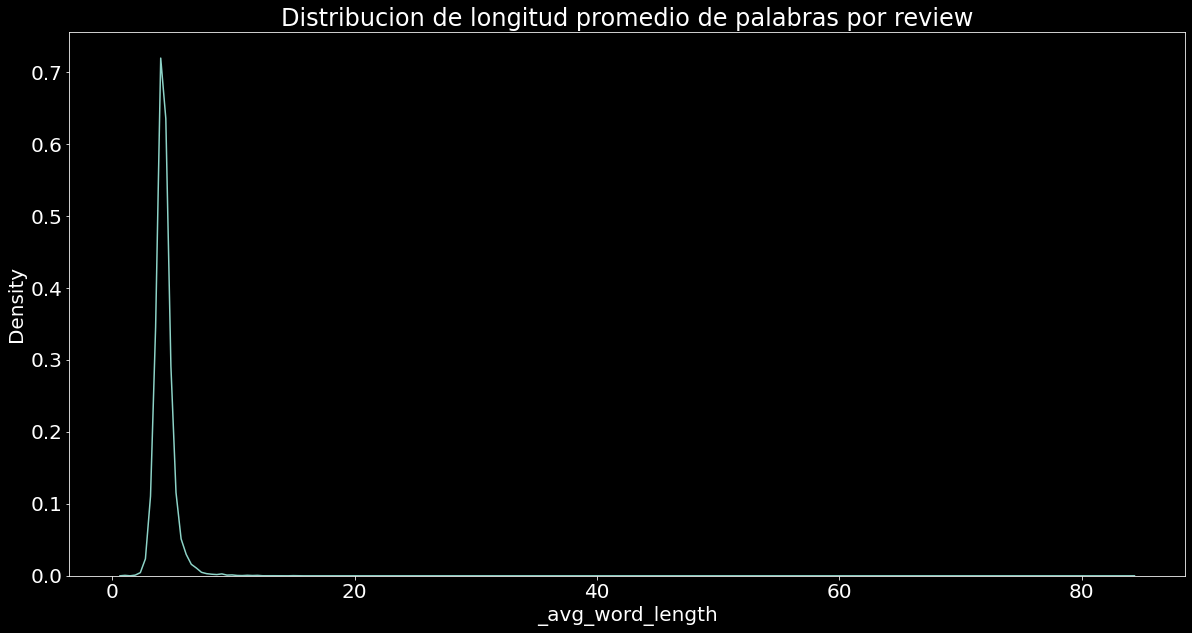

In [ ]:
plt.figure(figsize=(20, 10))
avg_word_length = features_vect['_avg_word_length']
sns.distplot(a=avg_word_length, hist=False)
plt.title('Distribucion de longitud promedio de palabras por review')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/letras_dist.png', transparent=True)

>**Conclusión:** tenemos en este caso una distribucion bastante simetrica, alterada levemente por algunos valores muy altos. Se limitó el dominio a 20 para poder visualizar mejor la distribucion

###**3.1.3 N_grams**

In [ ]:
def get_top_ngrams(data, n_gram):
  vec = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english').fit(data)
  bag_of_words = vec.transform(data)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) 
                for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
  x,y=map(list,zip(*words_freq)) 
  return x, y

**Unigramas**

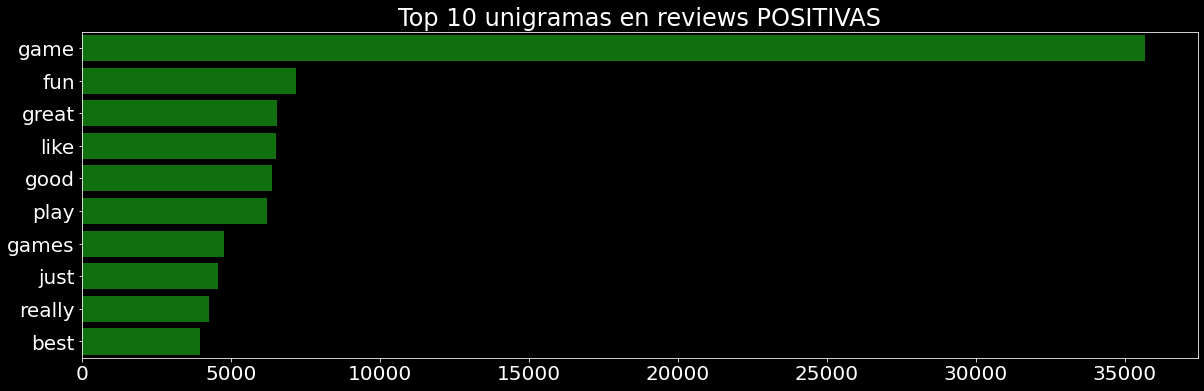

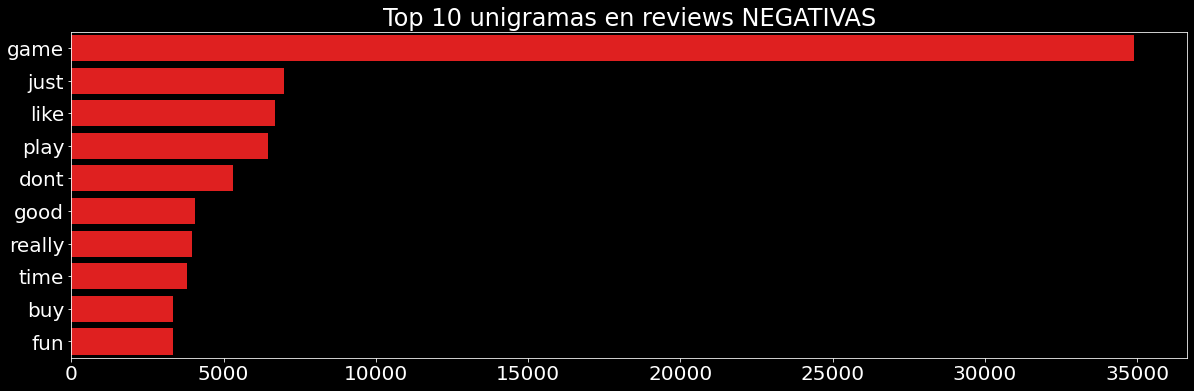

In [ ]:
x, y = get_top_ngrams(df[df['review_score'] == 1].review_text, 1)
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x, color='green').set(title='Top 10 unigramas en reviews POSITIVAS')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/unigram_pos.png', transparent=True)

x, y = get_top_ngrams(df[df['review_score'] == -1].review_text, 1)
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x, color='red').set(title='Top 10 unigramas en reviews NEGATIVAS')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/unigram_neg.png', transparent=True)

**Bigramas**

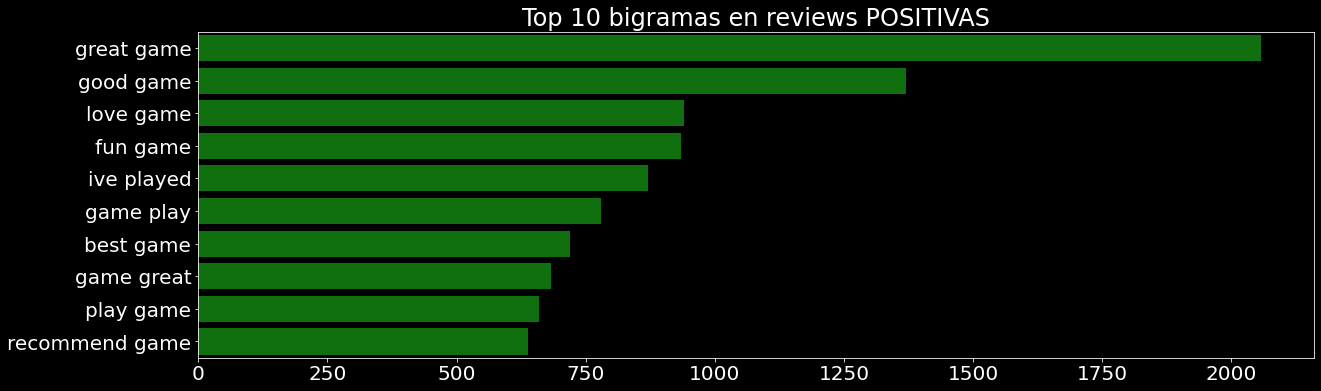

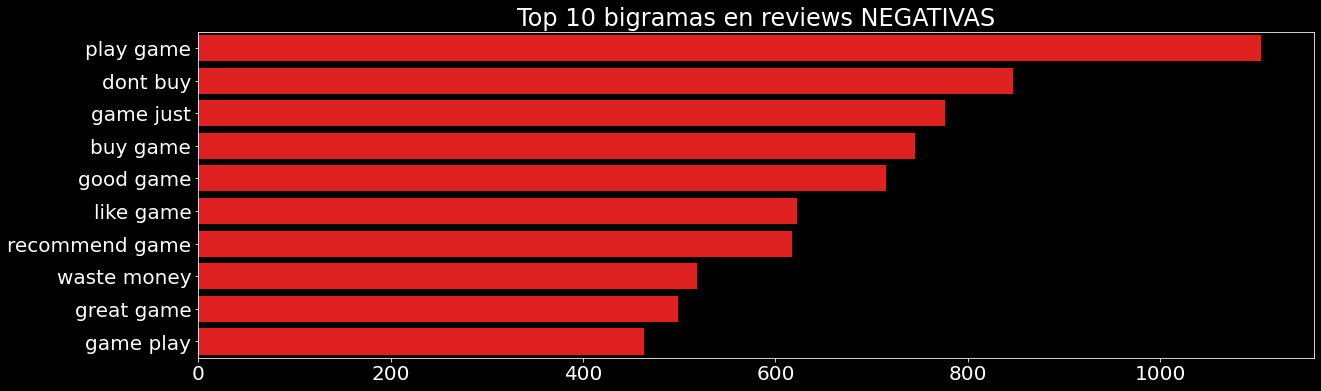

In [ ]:
x, y = get_top_ngrams(df[df['review_score'] == 1].review_text, 2)
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x, color='green').set(title='Top 10 bigramas en reviews POSITIVAS')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/biigram_pos.png', transparent=True)

x, y = get_top_ngrams(df[df['review_score'] == -1].review_text, 2)
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x, color='red').set(title='Top 10 bigramas en reviews NEGATIVAS')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/biigram_neg.png', transparent=True)

**Trigramas**

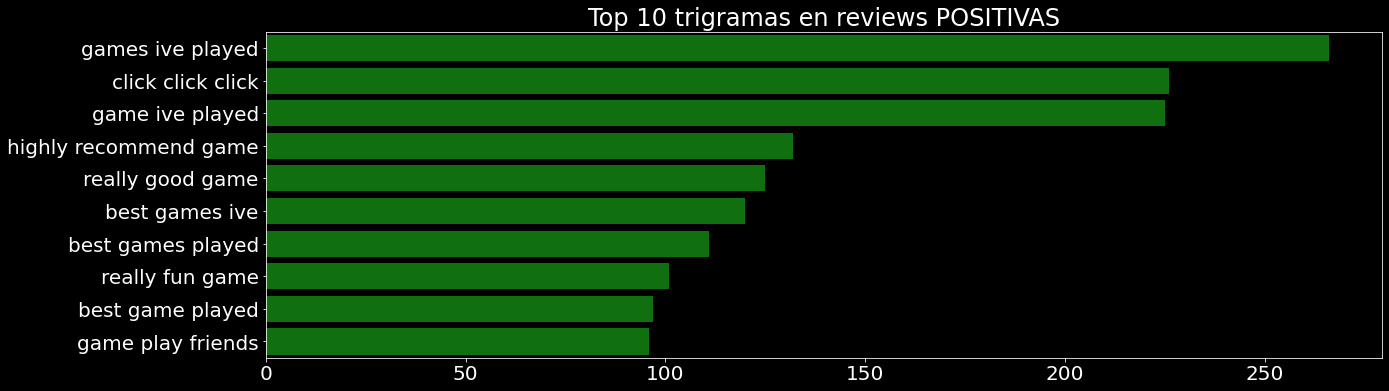

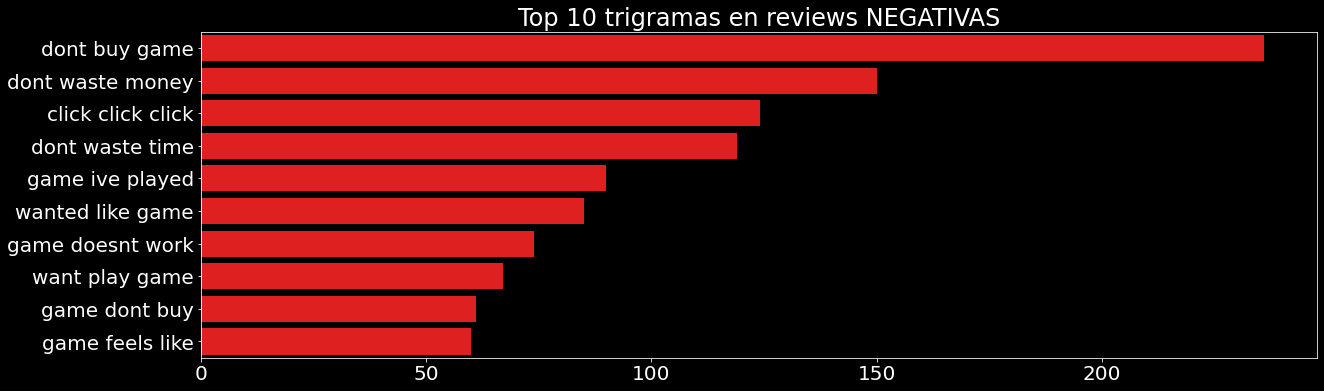

In [ ]:
x, y = get_top_ngrams(df[df['review_score'] == 1].review_text, 3)
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x, color='green').set(title='Top 10 trigramas en reviews POSITIVAS')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/trigram_pos.png', transparent=True)

x, y = get_top_ngrams(df[df['review_score'] == -1].review_text, 3)
plt.figure(figsize=(20, 6))
sns.barplot(x=y,y=x, color='red').set(title='Top 10 trigramas en reviews NEGATIVAS')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/trigram_neg.png', transparent=True)

##3.2 **Analisis de variables secundarias**

In [ ]:
list_genres = df.drop_duplicates(subset=['app_id']).genres.str.split(';', expand=True).stack().to_frame().reset_index(drop=True)
rank_genres = list_genres[0].value_counts()
print(f'TOP 10 GENEREOS QUE MAS SE REPITEN EN EL DATASET\n\n{rank_genres[:10]}')

TOP 10 GENEREOS QUE MAS SE REPITEN EN EL DATASET

Indie           2689
Action          2093
Adventure       1568
Casual          1052
Strategy        1047
RPG              845
Simulation       783
Free to Play     365
Racing           189
Sports           173
Name: 0, dtype: int64


**publisher**<br>
Cuales son las 10 compañias con mas juegos publicados en el dataset

In [ ]:
list_publi = df.drop_duplicates(subset=['app_id']).publisher.str.split(';', expand=True).stack().to_frame().reset_index(drop=True)
rank_publi = list_publi[0].value_counts()
print(f'TOP 10 COMPAÑIAS CON MAS PUBLICACIONES EN EL DATASET\n\n{rank_publi[:10]}')

TOP 10 COMPAÑIAS CON MAS PUBLICACIONES EN EL DATASET

Ubisoft                75
Square Enix            65
THQ Nordic             64
Strategy First         54
SEGA                   52
1C Entertainment       45
Paradox Interactive    42
Disney Interactive     41
Devolver Digital       39
2K                     38
Name: 0, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

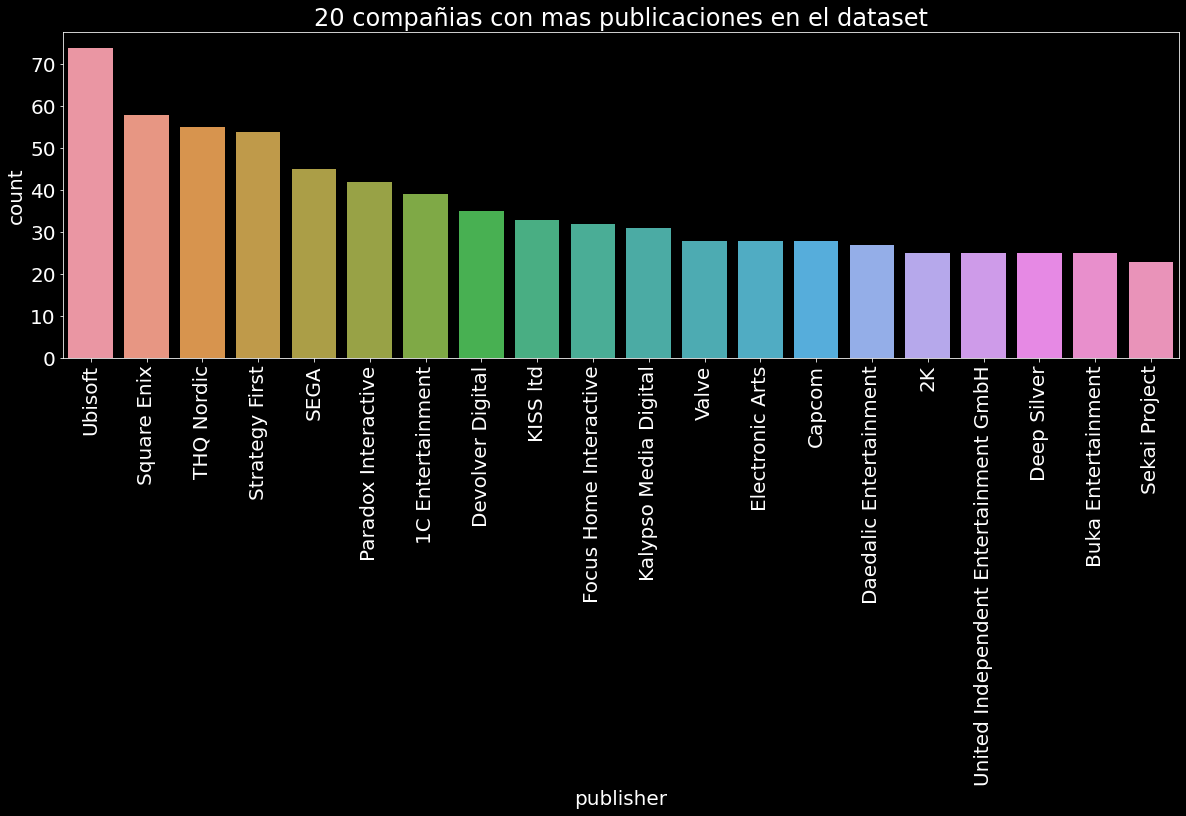

In [ ]:
plt.figure(figsize=(20, 6))
publisher = df.drop_duplicates(subset=['app_id']).publisher
sns.countplot(publisher, order = publisher.value_counts().iloc[:20].index, orient='h')
plt.title('20 compañias con mas publicaciones en el dataset')
plt.xticks(rotation=90)

**Conclusión:** Vemos que grandes compañias como Ubisoft, Strategy First o THQ Nordic son las que mas juegos publica. Lo que no quiere decir que eso sea bueno o mejor para la empresa. Cuando veamos el analisis de las reviews positivas y negativas por empresa veran a que nos referimos.

**price**<br>
Analizamos como se distribuyen los precios de los juegos.  

Nota: Tener en cuenta que el precio se encuentra en Libras Esterlinas (GBP)

In [ ]:
df_prices = df.drop_duplicates(subset=['app_id']).price
df_prices.describe().round(2)

count    4619.00
mean        7.62
std         7.47
min         0.00
25%         2.79
50%         5.99
75%        10.99
max        95.99
Name: price, dtype: float64

Text(0.5, 1.0, 'Distribucion de precios')

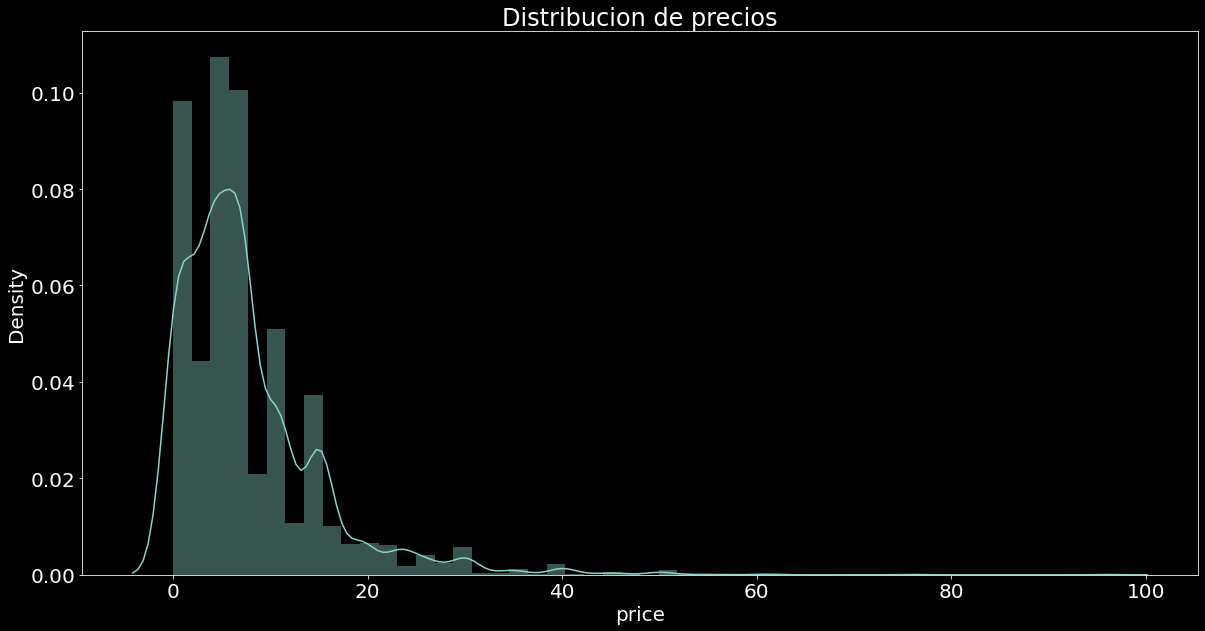

In [ ]:
plt.figure(figsize = (20, 10))
sns.distplot(a=df.drop_duplicates(subset=['app_id']).price, hist=True)
plt.title('Distribucion de precios')

**Conclusión:** Observamos una grafica asimetrica positiva debido a unos pocos juegos con precios excesivamente altos en relacion a la mayor densidad de juegos que van desde ser gratuitos a los 15 o 20 GBP.

**Relacion entre el review_score del juego y publisher**

Con esto buscamos ver la imagen que tienen los usuarios de la empresa publicante.

In [ ]:
pandas_df = df

df_publi_pos = pandas_df[['publisher','review_score']][pandas_df.review_score==1].groupby(['publisher','review_score']).agg(score_count_pos=('review_score','count')).sort_values(by='score_count_pos',ascending=False)
df_publi_neg = pandas_df[['publisher','review_score']][pandas_df.review_score==-1].groupby(['publisher','review_score']).agg(score_count_neg=('review_score','count')).sort_values(by='score_count_neg',ascending=False)
df_publi_merge = df_publi_pos.merge(df_publi_neg,how='inner',on='publisher').head(20)
df_publi_merge['pers_pos'] = round(df_publi_merge.score_count_pos/(df_publi_merge.score_count_pos + df_publi_merge.score_count_neg)*100,2)
df_publi_merge['pers_neg'] = round(df_publi_merge.score_count_neg/(df_publi_merge.score_count_pos + df_publi_merge.score_count_neg)*100,2)
df_publi_merge.head()

,score_count_pos,score_count_neg,pers_pos,pers_neg
publisher,,,,
Valve,2587,1098,70.20,29.80
Bethesda Softworks,1005,759,56.97,43.03
Ubisoft,899,1398,39.14,60.86
Re-Logic,745,90,89.22,10.78
Paradox Interactive,649,389,62.52,37.48


In [ ]:
fig = px.scatter(df_publi_merge, x='pers_pos', y='pers_neg', 
           color=df_publi_merge.index, title='Porcentaje de Reviews Score Positivas y Negativas por Empresa Publicante del Juego',
           labels={'pers_neg':'Porcentaje de Reviews Negativas', 'pers_pos':'Porcentaje de Reviews Positivas','publisher':'Empresas' })
fig.show()

**Conclusión:** Ahora, haciendo referencia a la conclusion obtenida cuando vimos la cantidad de juegos publicados por empresa, podemos ver claramente como la cantidad de juegos no hace a la calidad de los mismos. Ya que podemos ver como aproximadamente un 60% de los comentarios sobre los juegos de Ubisoft son negativos. Similar ocurre con la empresa Squere Enix, la cual tambien se encuentra entre las 5 empresas con mas juegos publicados, teniendo un 50/50 en relacion a los comentarios.

#**4. Modelos**

Nos quedamos solo con las reviews y los scores 

In [ ]:
df_p = df.iloc[:, [2,3]]                

###4.1 Sentence Embedding

Realizamos el embedding de la data con un modelo preentrenado de Google denominado **BERT** (Bidirectional Encoder Representations from Transformers o Representación de Codificador Bidireccional de Transformadores). "Este es una técnica basada en redes neuronales para el pre-entrenamiento del procesamiento del lenguaje natural (PLN)" [Wikipedia](https://es.wikipedia.org/wiki/BERT_(modelo_de_lenguaje))

A partir del cual, generamos un DataFrame conformado por tantas columnas como features tiene el modelo BERT (767 features) y tantas filas como reviews.
Cada una de las reviews es transformado en un array numerico generado por BERT. 

Instalamos el modelo preentrenado (**BERT**)

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

Creamos el DF con los embeddings

In [ ]:
#Sentence Embedding
#list_reviews_p = list(df_p.review_text)
#encode_reviews_p = sbert_model.encode(list_reviews_p, show_progress_bar=True)
#Creacion del DF
#df_emb_p = pd.DataFrame(encode_reviews_p)
#df_emb_p['score'] = df_p['review_score'].to_numpy()
#Agregamos score al DF
#df_emb_p.score = df_emb_p.score.replace(-1, 0)
#df_emb_p.head()

In [ ]:
#df_emb_p.to_csv('/content/drive/MyDrive/Proyecto_Final_DS/df_p.csv')

***Debido a que este proceso tarda demasiado tiempo como para volver a repetirlo cada vez que iniciamos el colab, decidimos guardar el dataframe resultante en un csv y cargarlo a continuacion.***

In [ ]:
df_emb_p = pd.read_csv('/content/drive/MyDrive/Proyecto_Final_DS/df_p.csv').drop(columns='Unnamed: 0')

In [ ]:
df_emb_p.shape

(65065, 385)

Creamos un conjunto de training y testing 

In [ ]:
from sklearn.model_selection import train_test_split

X_p = df_emb_p.drop(["score"], axis=1)
y_p = df_emb_p["score"]
(X_train_p, X_test_p, y_train_p, y_test_p) = train_test_split(X_p, y_p, test_size=0.30, random_state=42)

##4.2 **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Creamos modelo y lo entrenamos
model_rf = RandomForestClassifier()
model_rf.fit(X_train_p, y_train_p)
#Prediccion y accuracy
y_rf_pred_test = model_rf.predict(X_test_p)
y_rf_pred_train = model_rf.predict(X_train_p)
accuracy_rf_test = accuracy_score(y_test_p, y_rf_pred_test)
accuracy_rf_train = accuracy_score(y_train_p, y_rf_pred_train)
print(f'Accuracy Random Forest\n\n Test: {accuracy_rf_test}\n Train: {accuracy_rf_train}')

Accuracy Random Forest

 Test: 0.7831454918032786
 Train: 0.9947743989460973


Guardamos el modelo

In [ ]:
#joblib.dump(model_rf, '/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/rf.pkl')

##4.3 **LigthGBM**

In [ ]:
import lightgbm as lgb
#Creamos modelo y lo entrenamos
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_p, y_train_p)
#Prediccion y accuracy
y_lgb_pred_test = model_lgb.predict(X_test_p)
y_lgb_pred_train = model_lgb.predict(X_train_p)
accuracy_lgb_test = accuracy_score(y_test_p, y_lgb_pred_test)
accuracy_lgb_train = accuracy_score(y_train_p, y_lgb_pred_train)
print(f'Accuracy LigthGBM\n\n Test: {accuracy_lgb_test}\n Train: {accuracy_lgb_train}')

Accuracy LigthGBM

 Test: 0.8017418032786885
 Train: 0.8665056537490394


Guardamos el modelo

In [ ]:
#joblib.dump(model_lgb, '/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/lgb.pkl')

##4.4 **XGBoost**

In [ ]:
from xgboost import XGBClassifier
#Creamos modelo y lo entrenamos
model_xg = XGBClassifier(max_depth=3)
model_xg.fit(X_train_p, y_train_p)
#Prediccion y accuracy
y_xg_pred_test = model_xg.predict(X_test_p)
y_xg_pred_train = model_xg.predict(X_train_p)
accuracy_xg_test = accuracy_score(y_test_p, y_xg_pred_test)
accuracy_xg_train = accuracy_score(y_train_p, y_xg_pred_train)
print(f'Accuracy XGBoost\n\n Test: {accuracy_xg_test}\n Train: {accuracy_xg_train}')

Accuracy XGBoost

 Test: 0.7839651639344263
 Train: 0.8117685805247558


Guardamos el modelo

In [ ]:
#joblib.dump(model_xg, '/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/xgb.pkl')

#**5. Optimizacion de modelos**

Realizaremos una optimizacion de los parametros de los modelos de XGBoost y LightGBM. Para la optimizacion usaremos el metodo de Random Search CV de la libreria Sklearn

##5.1 Randomized Search CV

###5.1.1 LightGBM

Seteamos la lista de parametros con sus respectivas listas de valores que queremos que el Randomized Search utilice para crear los distintos modelos.

In [ ]:
params_lgb = {'boosting_type': ['gbdt'],
 'class_weight': [None],
 'colsample_bytree': [1.0],
 'importance_type': ['split'],
 'learning_rate': [0.1],
 'max_depth': [-1, 2, 4, 6],
 'min_child_samples': [20],
 'min_child_weight': [0.001],
 'min_split_gain': [0.0],
 'n_estimators': [170,200,250,300],
 'n_jobs': [-1],
 'num_leaves': [30,40,50, 55],
 'objective': [None],
 'random_state': [None],
 'reg_alpha': [0.0],
 'reg_lambda': [0.0],
 'silent': ['warn'],
 'subsample': [1.0],
 'subsample_for_bin': [200000],
 'subsample_freq': [0]}

Le pasamos al **RandomizedSearchCV** el modelo de LigthGBM, los parametros y la cantidad de iteraciones que queremos que realice. Cada iteracion se multiplica por el valor de Cross Validation y como el CV es por default 5, se van a generar 50 modelos.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
#Creamos modelo y lo entrenamos
model = lgb.LGBMClassifier()
model_lgb_opt = RandomizedSearchCV(estimator=model, param_distributions=params_lgb, n_iter=10, n_jobs=-1)
model_lgb_opt.fit(X_train_p, y_train_p)
#Prediccion y accuracy
y_lgb_opt_pred_test = model_lgb_opt.predict(X_test_p)
y_lgb_opt_pred_train = model_lgb_opt.predict(X_train_p)
accuracy_lgb_opt_test = accuracy_score(y_test_p, y_lgb_opt_pred_test)
accuracy_lgb_opt_train = accuracy_score(y_train_p, y_lgb_opt_pred_train)

Guardamos el modelo optimizado

In [ ]:
#joblib.dump(model_lgb_opt, '/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/lgb_opt_2.pkl')

['/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/lgb_opt_2.pkl']

###5.1.2 XGBoost

Seteamos la lista de parametros con sus respectivas listas de valores que queremos que el Randomized Search utilice para crear los distintos modelos.

In [ ]:
from scipy import stats
params_xgb = {'n_estimators': stats.randint(200,270),
              'learning_rate': stats.uniform(0.01, 0.15), 
              'subsample': stats.uniform(0.2, 0.65),
              'max_depth': [2,3,4,5],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4],
              'lambda': [1,2,3,4,5]
             }

Le pasamos al **RandomizedSearchCV** el modelo de XGBoost, los parametros y la cantidad de iteraciones que queremos que realice. Cada iteracion se multiplica por el valor de Cross Validation y como el CV es por default 5, se van a generar 25 modelos.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

#Creamos modelo y lo entrenamos
model = XGBClassifier()

model_xgb_opt = RandomizedSearchCV(estimator=model, param_distributions=params_xgb, n_iter=5, n_jobs=-1)
model_xgb_opt.fit(X_train_p, y_train_p)
#Prediccion y accuracy
y_xgb_opt_pred_test = model_xgb_opt.predict(X_test_p)
y_xgb_opt_pred_train = model_xgb_opt.predict(X_train_p)
accuracy_xgb_opt_test = accuracy_score(y_test_p, y_xgb_opt_pred_test)
accuracy_xgb_opt_train = accuracy_score(y_train_p, y_xgb_opt_pred_train)

Guardamos el modelo optimizado

In [ ]:
#joblib.dump(model_xgb_opt, '/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/xgb_opt.pkl')

#**6. Comparacion de modelos**

Lectura de los modelos guardados

In [ ]:
rf = joblib.load("/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/rf.pkl")
lgb = joblib.load("/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/lgb.pkl")
xgb = joblib.load("/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/xgb.pkl")
lgb_opt = joblib.load("/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/lgb_opt.pkl")
xgb_opt = joblib.load("/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/xgb_opt.pkl")

##6.1 Accuracy, Presicion y Recall

Predicción conjunto test

In [ ]:
y_rf_pred_test = rf.predict(X_test_p)
y_lgb_pred_test = lgb.predict(X_test_p)
y_xgb_pred_test = xgb.predict(X_test_p)
y_lgb_opt_pred_test = lgb_opt.predict(X_test_p)
y_xgb_opt_pred_test = xgb_opt.predict(X_test_p)

Predicción conjunto train

In [ ]:
y_rf_pred_train = rf.predict(X_train_p)
y_lgb_pred_train = lgb.predict(X_train_p)
y_xgb_pred_train = xgb.predict(X_train_p)
y_lgb_opt_pred_train = lgb_opt.predict(X_train_p)
y_xgb_opt_pred_train = xgb_opt.predict(X_train_p)

Accuracy test

In [ ]:
accuracy_rf_test = accuracy_score(y_test_p, y_rf_pred_test)
accuracy_lgb_test = accuracy_score(y_test_p, y_lgb_pred_test)
accuracy_xgb_test = accuracy_score(y_test_p, y_xgb_pred_test)
accuracy_lgb_opt_test = accuracy_score(y_test_p, y_lgb_opt_pred_test)
accuracy_xgb_opt_test = accuracy_score(y_test_p, y_xgb_opt_pred_test)

Accuracy train

In [ ]:
accuracy_rf_train = accuracy_score(y_train_p, y_rf_pred_train)
accuracy_lgb_train = accuracy_score(y_train_p, y_lgb_pred_train)
accuracy_xgb_train = accuracy_score(y_train_p, y_xgb_pred_train)
accuracy_lgb_opt_train = accuracy_score(y_train_p, y_lgb_opt_pred_train)
accuracy_xgb_opt_train = accuracy_score(y_train_p, y_xgb_opt_pred_train)

Precision

In [ ]:
presicion_rf = precision_score(y_test_p, y_rf_pred_test)
presicion_lgb = precision_score(y_test_p, y_lgb_pred_test)
presicion_xgb = precision_score(y_test_p, y_xgb_pred_test)
presicion_lgb_opt = precision_score(y_test_p, y_lgb_opt_pred_test)
presicion_xgb_opt = precision_score(y_test_p, y_xgb_opt_pred_test)

Recall

In [ ]:
recall_rf = recall_score(y_test_p, y_rf_pred_test)
recall_lgb = recall_score(y_test_p, y_lgb_pred_test)
recall_xgb = recall_score(y_test_p, y_xgb_pred_test)
recall_lgb_opt = recall_score(y_test_p, y_lgb_opt_pred_test)
recall_xgb_opt = recall_score(y_test_p, y_xgb_opt_pred_test)

Visualizacion de los resultados

In [ ]:
df_comparacion = pd.DataFrame({'Model': ['Random Forest', 'LightGBM', 'XGBoost', 'LightGBM_opt', 'XGBoost_opt'],
                                'Accuracy_test': [accuracy_rf_test, accuracy_lgb_test, accuracy_xg_test, accuracy_lgb_opt_test, accuracy_xgb_opt_test],
                                'Accuracy_train': [accuracy_rf_train, accuracy_lgb_train, accuracy_xg_train, accuracy_lgb_opt_train, accuracy_xgb_opt_train],
                                'Presicion': [presicion_rf, presicion_lgb, presicion_xgb, presicion_lgb_opt, presicion_xgb_opt],
                                'Recall': [recall_rf, recall_lgb, recall_xgb, recall_lgb_opt, recall_xgb_opt]}).set_index('Model')

df_comparacion = df_comparacion.style.highlight_max(color = 'green', axis = 0)
df_comparacion

,Accuracy_test,Accuracy_train,Presicion,Recall
Model,,,,
Random Forest,0.783760,0.994774,0.785552,0.822863
LightGBM,0.801742,0.866506,0.810151,0.824957
XGBoost,0.783965,0.811769,0.790003,0.815344
LightGBM_opt,0.915574,0.916983,0.919651,0.923853
XGBoost_opt,0.804816,0.872741,0.815373,0.823910


##6.2 Curva ROC

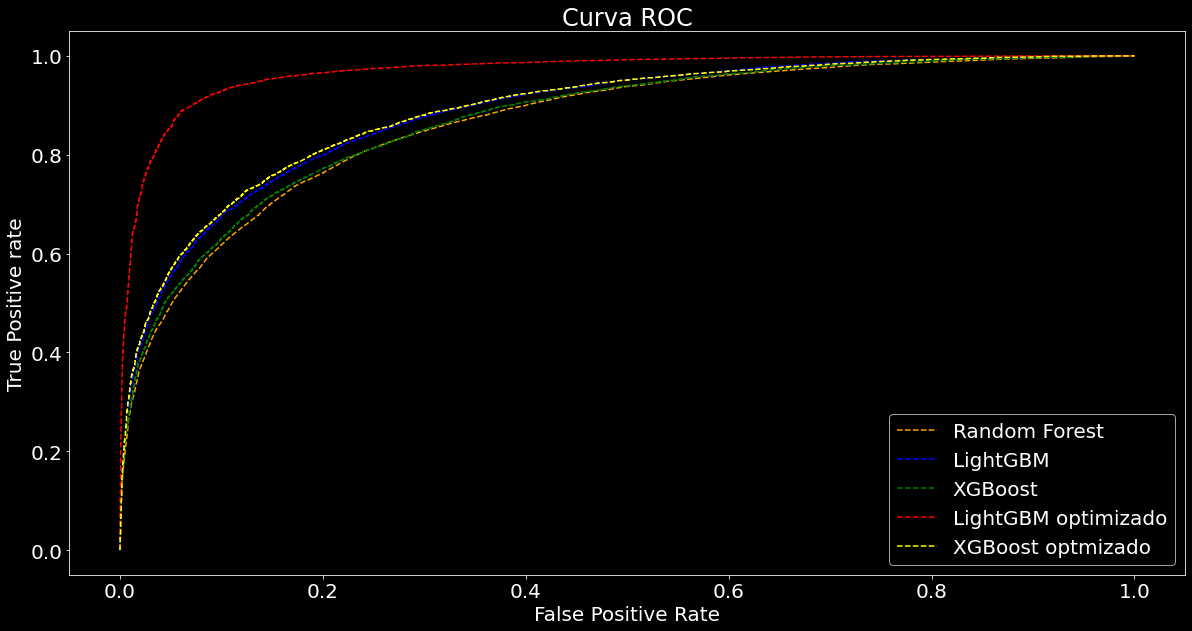

In [ ]:
from sklearn.metrics import roc_curve

plt.figure(figsize = (20, 10))

y_predict_proba_rf = rf.predict_proba(X_test_p)
y_predict_proba_lgb = lgb.predict_proba(X_test_p)
y_predict_proba_xgb = xgb.predict_proba(X_test_p)
y_predict_proba_lgb_opt = lgb_opt.predict_proba(X_test_p)
y_predict_proba_xgb_opt = xgb_opt.predict_proba(X_test_p)

fpr_rf, tpr_rf, _ = roc_curve(y_test_p,  y_predict_proba_rf[:,1], pos_label=1)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test_p,  y_predict_proba_lgb[:,1], pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_p,  y_predict_proba_xgb[:,1], pos_label=1)
fpr_lgb_opt, tpr_lgb_opt, _ = roc_curve(y_test_p,  y_predict_proba_lgb_opt[:,1], pos_label=1)
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(y_test_p,  y_predict_proba_xgb_opt[:,1], pos_label=1)

plt.plot(fpr_rf, tpr_rf, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr_lgb, tpr_lgb, linestyle='--',color='blue', label='LightGBM')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--',color='green', label='XGBoost')
plt.plot(fpr_lgb_opt, tpr_lgb_opt, linestyle='--',color='red', label='LightGBM optimizado')
plt.plot(fpr_xgb_opt, tpr_xgb_opt, linestyle='--',color='yellow', label='XGBoost optmizado')

plt.title('Curva ROC')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('/content/drive/MyDrive/Proyecto_Final_DS/resultados/ROC_comparacion.png', transparent=True)
plt.show()

#**7. Evaluacion del modelo**

##7.1 Matriz de confusion

[Text(0, 0.5, 'Negativo'), Text(0, 1.5, 'Positivo')]

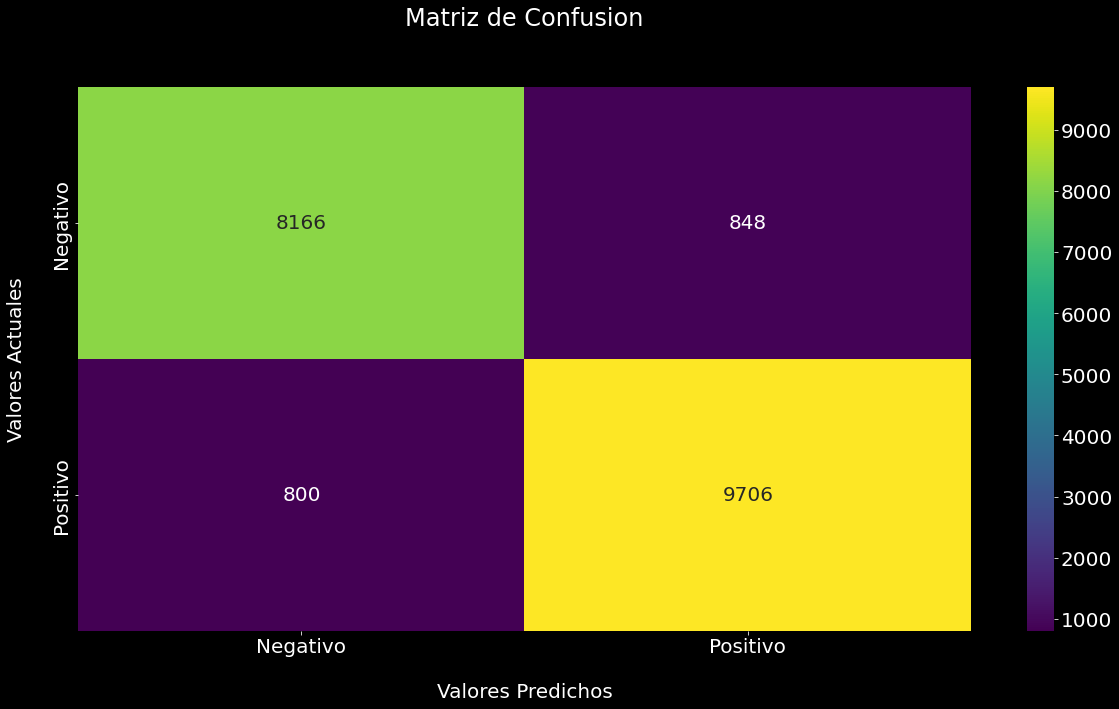

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test_p, y_lgb_opt_pred_test)

plt.figure(figsize = (20, 10))

ax = sns.heatmap(cm, annot=True, cmap='viridis', fmt="d")

ax.set_title('Matriz de Confusion\n\n');
ax.set_xlabel('\nValores Predichos')
ax.set_ylabel('Valores Actuales\n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negativo','Positivo'])
ax.yaxis.set_ticklabels(['Negativo','Positivo'])

## Display the visualization of the Confusion Matrix.


## 7.2 Precision

In [ ]:
from sklearn.metrics import precision_score

presicion = precision_score(y_test_p, y_lgb_opt_pred_test)
print(f'Presicion: {presicion}')

Presicion: 0.9196513170361948


## 7.3 Recall

In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(y_test_p, y_lgb_opt_pred_test)
print(f'Recall: {recall}')

Recall: 0.9238530363601751


##7.4 Curva ROC

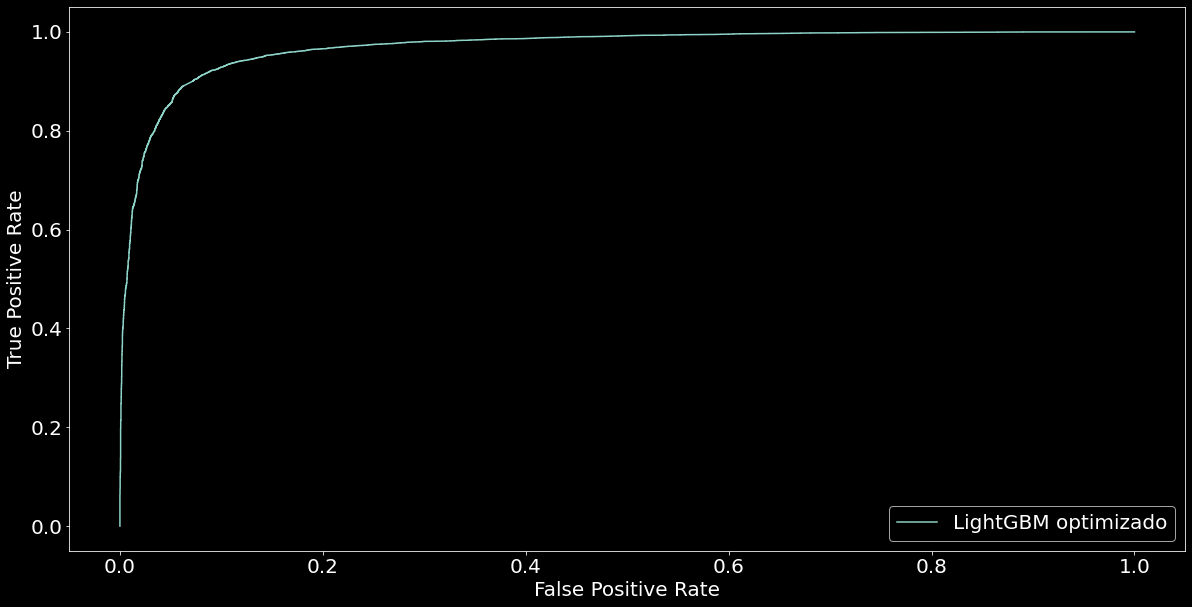

In [ ]:
from sklearn.metrics import roc_curve

y_predict_proba = lgb_opt.predict_proba(X_test_p)
fpr, tpr, _ = roc_curve(y_test_p,  y_predict_proba[:,1], pos_label=1)

plt.figure(figsize=(20, 10))
plt.plot(fpr,tpr, label='LightGBM optimizado')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='best')
plt.show()

##7.5 AUC

In [ ]:
from sklearn.metrics import roc_auc_score

predict_proba = lgb_opt.predict_proba(X_test_p)
auc_score = roc_auc_score(y_test_p, predict_proba[:,1])

print(f'AUC: {auc_score}')

AUC: 0.9688446174491518


##7.6 Probabilidad de prediccion

Text(0.5, 1.0, 'Distribucion de probabilidades en prediccion de review negativa')

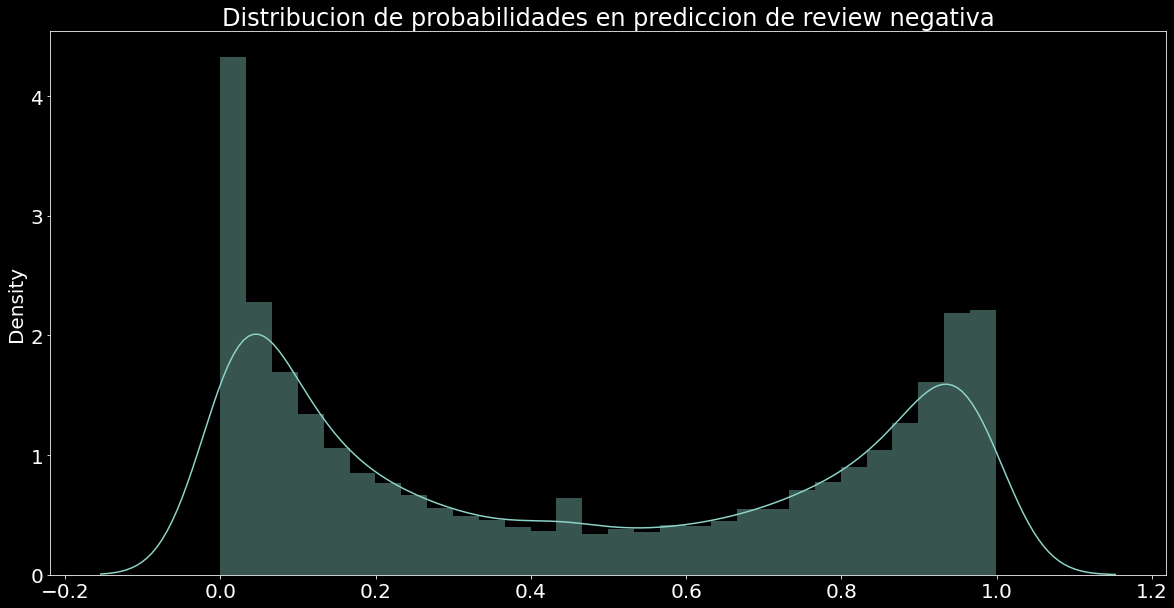

In [ ]:
predict_proba = lgb_opt.predict_proba(X_test_p)
plt.figure(figsize=(20, 10))

sns.distplot(a=predict_proba[:, 0], hist=True, bins=30)
plt.title('Distribucion de probabilidades en prediccion de review negativa')

##7.7 Testing

###7.7.1 Testing automatico

In [ ]:
print('Test de modelo con 30 reviews extraidas del conjunto testing\n\n')
for i in range(30):
  df_index = X_test_p.index[i]
  review = df_p.iloc[df_index]
  encode_text = sbert_model.encode(review.review_text).reshape(1, -1)
  pred_proba = lgb_opt.predict_proba(encode_text)[0]
  #       Texto de la review    Score original de la review   Probabilidad que sea negativa y probabilidad que sea positiva segun la prediccion del modelo
  print(f'{review.review_text}\nScore: {review.review_score}\nProbabilidad Negativa: {pred_proba[0]}\nProbabilidad Positiva: {pred_proba[1]}\n')

Test de modelo con 30 reviews extraidas del conjunto testing


still feels like it has a lot of bugs
Score: -1
Probabilidad Negativa: 0.867944674681083
Probabilidad Positiva: 0.13205532531891698

pretty big game like mandy lol ign would like bully too
Score: 1
Probabilidad Negativa: 0.16196138081546818
Probabilidad Positiva: 0.8380386191845318

not worth your time its one battle worthless voice acting no real plot one of the most pathetic things ive ever seen
Score: -1
Probabilidad Negativa: 0.9067791851970665
Probabilidad Positiva: 0.09322081480293354

hilariously glitchy and just plain fun
Score: 1
Probabilidad Negativa: 0.3844595676605228
Probabilidad Positiva: 0.6155404323394772

this is awesome but sometimes we got server problem but at least this greatest game i ever played
Score: 1
Probabilidad Negativa: 0.32067260462911584
Probabilidad Positiva: 0.6793273953708842

one the best rts games of all time gets an hd overhaul a better game engine that provides higher resolutions more 

###7.7.2 Testing manual

Para testear el modelo manualmente ejecutar las siguientes celdas

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
model_load = joblib.load("/content/drive/MyDrive/Proyecto_Final_DS/resultados/modelos/lgb_opt.pkl")

text = input('Escriba una review en ingles\n\n')
encode_text = sbert_model.encode(text).reshape(1, -1)
pred = model_load.predict(encode_text)
pred_proba = model_load.predict_proba(encode_text)
if pred[0] == 0:
  print('\nNegativo')
  print(f'Probabilidad: {pred_proba[0][0]}')
else:
  print('\nPositivo')
  print(f'Probabilidad: {pred_proba[0][1]}')

Escriba una review en ingles

Not good enough

Negativo
Probabilidad: 0.7937495275730946


#**8. Conclusiones**

 ### **Interpretacion de los Resultados**

Se elaboro un modelo para analizar una base de datos conformada por reviews de videojuegos dentro de la plataforma Steam.
Se considero una muestra de 100.000 reviews con un balance del 51% reviews positivas y 49% negativas, provenientes de una base datos de 6.4 Millones de reviews.
A partir de la misma, se obtuvieron los marcadores del lenguaje y construcciones de texto comunes a cada una de las submuestras.

Luego de la preparación y elaboración de varios modelos de Machine Learning,  se adquirió un modelo que permite evaluar reviews similares desde otros contextos a los datos tomados con un accuracy del 91%. El modelo fue generado en base a reviews de Steam, y con el mismo, se pueden predecir valores tomados de otras redes sociales o fuentes de texto, prediciendo de esta manera el posible sentimiento de una mención en twitter de un juego específico, por ejemplo. 

El modelo nos permite identificar tendencias lingüísticas que conforman un sentimiento positivo o negativo en una review, contextualizado en el producto analizado. 
El entrenamiento del modelo nos permite evaluar texto e interpretarlo como una review positiva o negativa dependiendo de los marcadores comunes que se encuentren en el texto.


### **Interpretacion del lenguaje analizado**
Estas construcciones de lenguaje pueden adjudicarse a distintos grupos culturales que comparten ciertas características entre sí (interés común en videojuegos, un rango etario especifico de consumo de producto, normas culturales comunes dentro de las comunidades internas del juego). Un análisis más profundo nos permitiría inclusive adjudicar modismos específicos por género de videojuego, e inclusive hacer determinaciones de cambios lingüísticos a través del tiempo. 
Llevandolo un poco mas lejos aún, podria ayudar a determinar si en una review hay comentarios acerca del algun bug en el juego, lo que ayudaria enormemente a las empresas a arreglar de manera inmediata los mismos y mejorar la calidad de sus juegos para inclinar la balanza al lado positivo.  
